In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [67]:
import requests
from io import StringIO

orig_url='https://drive.google.com/file/d/1LpdYB1q8I9A97tkvWrFBLpgGmMVAkXjP/view?usp=sharing"'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
country_df = pd.read_csv(csv_raw)
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [68]:
#basics of data
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


- There are no null values so we do not need to clean any data 

In [69]:
#shape of the data
country_df.shape

(167, 10)

In [70]:
#checking if there is any duplicate rows and dropping it
country_df.drop_duplicates(keep='first',inplace=True)
country_df.shape

(167, 10)

- __No duplicates were found__

In [71]:
#stats of the data 
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


- Looking at the above info it seems there are outliers in the below variables 
    - child moratlity
    - Exports
    - imports
    - income
    - inflation
    - gdpp 
   
  We will verify this statistacally later

In [72]:
#Data transformation
#We are converting the data columns which are in percentage into numbers

country_df['exports'] = country_df['exports'] * country_df['gdpp'] /100
country_df['imports'] = country_df['imports'] * country_df['gdpp'] /100
country_df['health'] = country_df['health'] * country_df['gdpp'] /100


In [73]:
numerical=['int64','float64']
num_cols=country_df.select_dtypes(include=numerical).columns
num_cols

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

## EDA

In [74]:
def univariate_num(df):
    from scipy.stats import norm
    dtype_num=['float64','int64']
    col_names=df.select_dtypes(include=dtype_num).columns
    for columns in col_names:
        sns.set(style="whitegrid")
        plt.figure(figsize=(11,4))
        plt.subplot(121)
        plt.title(f'Distplot of {columns}')
        sns.distplot(df[columns].dropna(),fit=norm,kde=False)

        plt.subplot(122)
        plt.title(f'Boxplot  of {columns}')
        sns.boxplot(y=df[columns].dropna())
        plt.show()

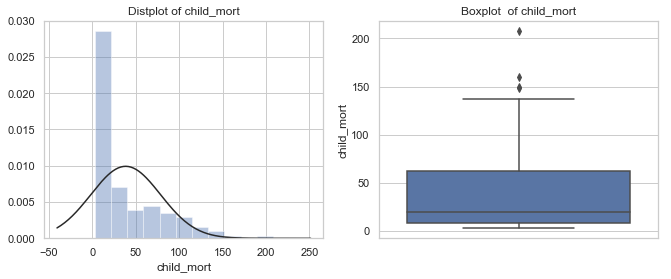

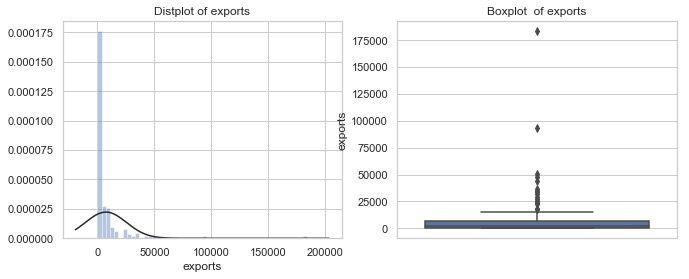

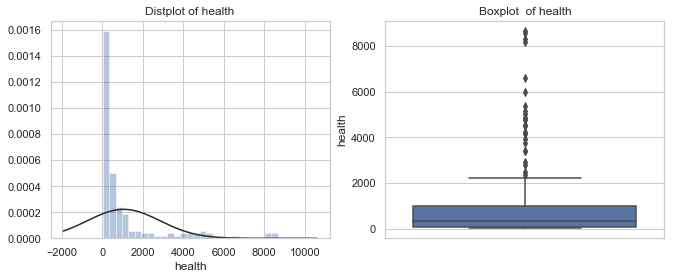

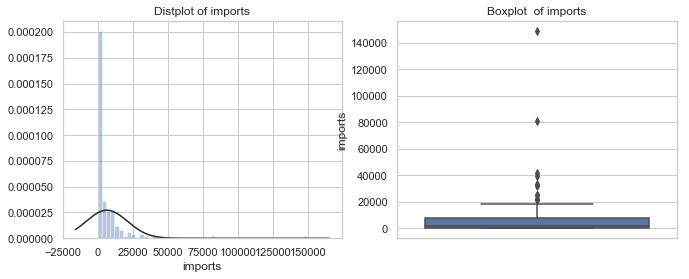

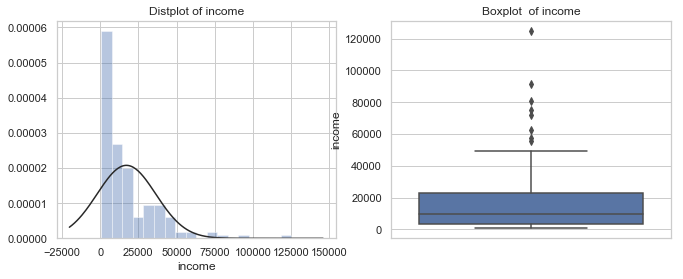

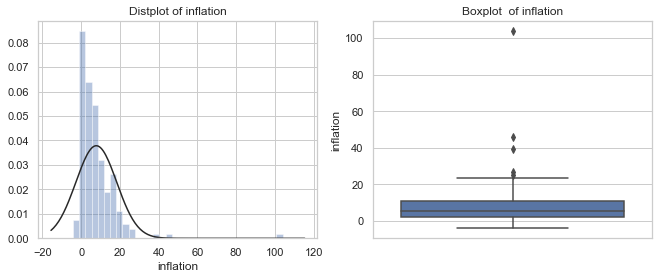

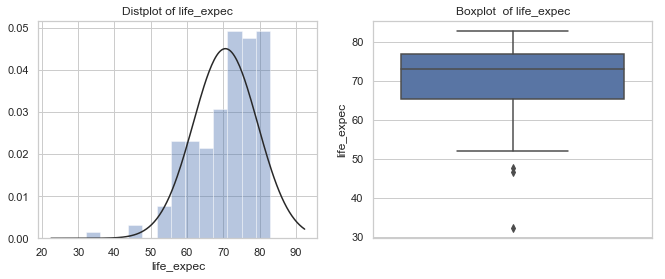

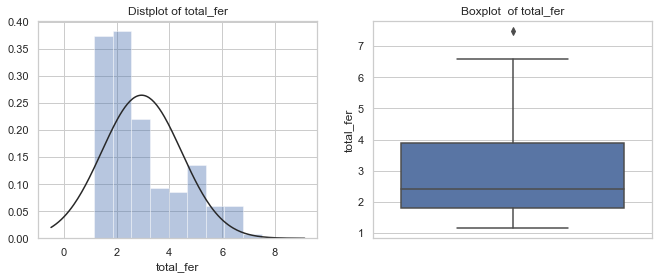

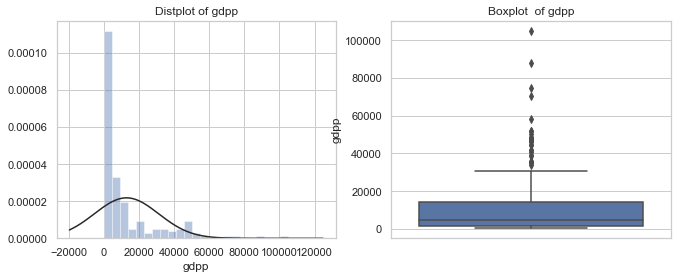

In [75]:
univariate_num(country_df)

In [76]:
#correlation between the variables
def bivariate_num(df):
    temp_df=df.select_dtypes(include=['float64','int32'])
    cor=round(temp_df.corr(),2)
    plt.figure(figsize=(10,8))
    ax=plt.axes()
    sns.heatmap(cor,annot=True,fmt='.1f',cmap='coolwarm',ax=ax)
    ax.set_title('Heatmap showing correlated values for the Numerical data')
    plt.show()

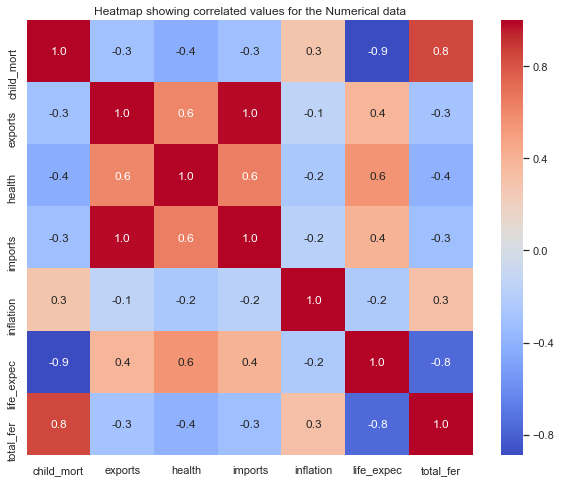

In [77]:
bivariate_num(country_df)

#### As seen from the EDA :
- There are outliers in the income,gdpp,imnports,exports and child mortality variables
- The below variable pairs are highly correlated
    1. Total Fertility and life expectency
    2. Total Fertility and child moratlity 
    3. Life expectancy and child mortality

## Outlier Treatment

In [78]:
#This is a function to check if we have outliers in any of the columns
# The assumption here is that if any data point lies below 1.5* IQR of Q1 and 1.5*IQR above Q3 , it is an outlier.
def outlier(col):
    for i in col:        
        temp=country_df[i].describe()
        IQR=temp['75%']-temp['25%']
        LO=temp['25%']-1.5*IQR
        HO=temp['75%']+1.5*IQR
        if (temp['min']<LO) | (temp['max']>HO):
            count=len(country_df[country_df[i] < LO].index)
            count=count+len(country_df[country_df[i] > HO].index)
            
            per =round((count/len(country_df[i].index))*100,2)
            #print("{} has {}% outliers".format(i,per))
            print("{} has {} outliers which is {} % if the data column".format(i,count,per))
        else:
            print("{} has no outliers".format(i))

In [79]:
numcols=list(country_df.columns)
numcols.remove('country')
outlier(numcols)



child_mort has 4 outliers which is 2.4 % if the data column
exports has 18 outliers which is 10.78 % if the data column
health has 24 outliers which is 14.37 % if the data column
imports has 12 outliers which is 7.19 % if the data column
income has 8 outliers which is 4.79 % if the data column
inflation has 5 outliers which is 2.99 % if the data column
life_expec has 3 outliers which is 1.8 % if the data column
total_fer has 1 outliers which is 0.6 % if the data column
gdpp has 25 outliers which is 14.97 % if the data column


__We are not treating any oulier as treating them will result in huge data loss which might affect our analysis__

## Preparing for model


In [80]:
#Scalling the data using standard scaler 
scaled_df=country_df.drop('country',axis=1)
cols=scaled_df.columns
scaler=StandardScaler()
scaled_df=scaler.fit_transform(scaled_df)
scaled_df.shape


(167, 9)

In [81]:
scaled_df=pd.DataFrame(scaled_df)
scaled_df.columns=cols
scaled_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.411011,-0.565040,-0.432276,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.350191,-0.439218,-0.313677,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.318526,-0.484826,-0.353720,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,-0.291375,-0.532363,-0.345953,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,-0.104331,-0.178771,0.040735,0.101732,-0.601749,0.704258,-0.541946,-0.041817


## PCA 

In [82]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=100)

In [83]:
#doing pca on the scaled data which we prepared
pca.fit(scaled_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='randomized', tol=0.0, whiten=False)

#### Lets explore the scree plot to decide on number of principle components

In [84]:
pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

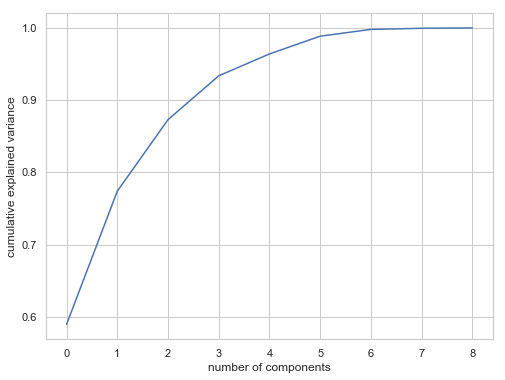

In [85]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

- __As we can see that we need 4 components which are explaining more than 95% of the variance__

In [86]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=4)

In [87]:
country_pca_df=pca_final.fit_transform(scaled_df)
country_pca_df.shape

(167, 4)

In [88]:
temp_df=pd.DataFrame(country_pca_df)
temp_df.corr()

,0,1,2,3
0,1.000000,0.000919,-0.000652,-0.004515
1,0.000919,1.000000,-0.000257,-0.015302
2,-0.000652,-0.000257,1.000000,0.008959
3,-0.004515,-0.015302,0.008959,1.000000


- As can be clearly seen there is no correlation between the principal components

__1. Now we have PC with us , we need to clueter them to get our required segments__

__2.  Before applying clustering to it we need to check the cluster tendency of the data which is generated by PCA . This can be validated by using Hopkins statistics__



In [89]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [90]:
country_pca_df=pd.DataFrame(country_pca_df)
for i in range(10):
    print(hopkins(country_pca_df))

0.8883124971246076
0.7960218653601082
0.9511269548633137
0.900043132709856
0.927766390963778
0.8186905033528168
0.9338963749378394
0.9415580432596787
0.9044891778888248
0.9389617368247705


__As we can see that the hopkins values has at an average hopkins values well above 0.5. We can say it definately has a cluster tendency__

__Lets check the number of clusters we can take for the data set by checking with silhoette score and elbow curve__

## K means clustering

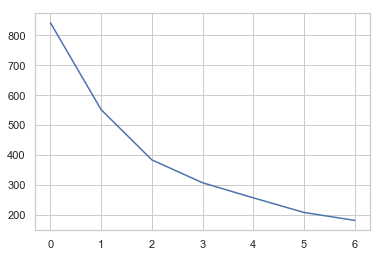

In [91]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(country_pca_df)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [92]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state=32)
    kmeans.fit(country_pca_df)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(country_pca_df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.48686868639649855
For n_clusters=3, the silhouette score is 0.46706199059895176
For n_clusters=4, the silhouette score is 0.4756748841906573
For n_clusters=5, the silhouette score is 0.4828275984325322
For n_clusters=6, the silhouette score is 0.45632605100332796
For n_clusters=7, the silhouette score is 0.3750771469665226
For n_clusters=8, the silhouette score is 0.3677819577344607


__By looking at both the silhouette score as well as the elbow graph we can take 3 number of clusters__

In [93]:
#Using K means clustering algorithm
kmeans = KMeans(n_clusters=3, max_iter=50,random_state=32)
kmeans.fit(country_pca_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=32, tol=0.0001, verbose=0)

In [94]:
kmeans.labels_

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [95]:
country_df['Kmeans_cluster']=kmeans.labels_

In [96]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Kmeans_cluster
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1


In [97]:
#creating a new df containinig the principal components together with the cluter lables
country_pca_new_df=country_pca_df.copy()

In [98]:
country_pca_new_df.columns=['PC1','PC2','PC3','PC4']

In [99]:
country_pca_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 4 columns):
PC1    167 non-null float64
PC2    167 non-null float64
PC3    167 non-null float64
PC4    167 non-null float64
dtypes: float64(4)
memory usage: 5.3 KB


In [100]:
country_pca_new_df['country']=country_df['country']

country_pca_new_df.head()

,PC1,PC2,PC3,PC4,country
0,-2.636647,1.472085,-0.546500,0.237267,Afghanistan
1,-0.023845,-1.435816,-0.009080,-0.442921,Albania
2,-0.459260,-0.678794,0.967852,-0.176389,Algeria
3,-2.723581,2.176018,0.597794,0.438919,Angola
4,0.648777,-1.026498,-0.244170,-0.267513,Antigua and Barbuda


In [101]:
country_pca_new_df['Kmeans_cluster']=country_df['Kmeans_cluster']

In [102]:
country_pca_new_df.head()

,PC1,PC2,PC3,PC4,country,Kmeans_cluster
0,-2.636647,1.472085,-0.546500,0.237267,Afghanistan,0
1,-0.023845,-1.435816,-0.009080,-0.442921,Albania,1
2,-0.459260,-0.678794,0.967852,-0.176389,Algeria,1
3,-2.723581,2.176018,0.597794,0.438919,Angola,0
4,0.648777,-1.026498,-0.244170,-0.267513,Antigua and Barbuda,1


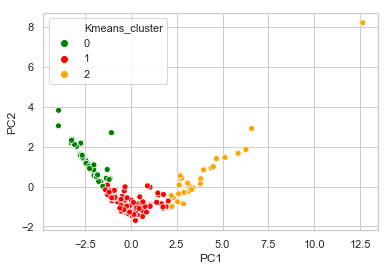

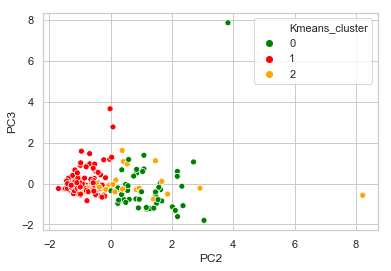

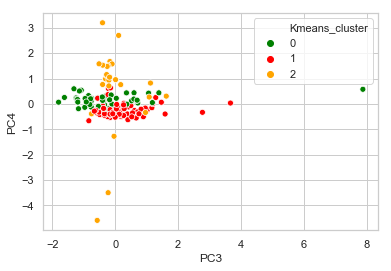

In [103]:
#visualization on PCA components 
sns.scatterplot(x='PC1',y='PC2',hue='Kmeans_cluster',data=country_pca_new_df,palette=['green','red','orange'])
plt.show()
sns.scatterplot(x='PC2',y='PC3',hue='Kmeans_cluster',data=country_pca_new_df,palette=['green','red','orange'])
plt.show()
sns.scatterplot(x='PC3',y='PC4',hue='Kmeans_cluster',data=country_pca_new_df,palette=['green','red','orange'])
plt.show()

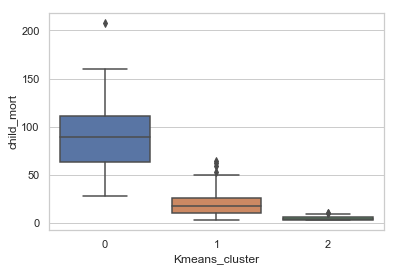

In [104]:
sns.boxplot(x='Kmeans_cluster', y='child_mort', data=country_df)

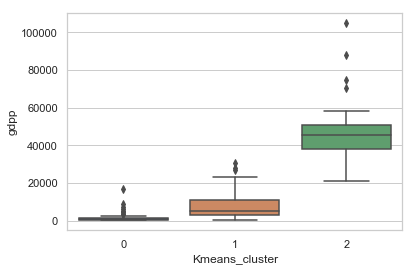

In [105]:
sns.boxplot(x='Kmeans_cluster', y='gdpp', data=country_df)

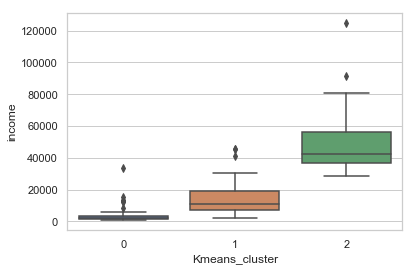

In [106]:
sns.boxplot(x='Kmeans_cluster', y='income', data=country_df)

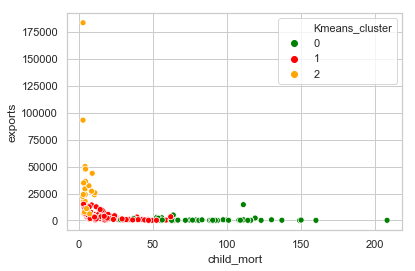

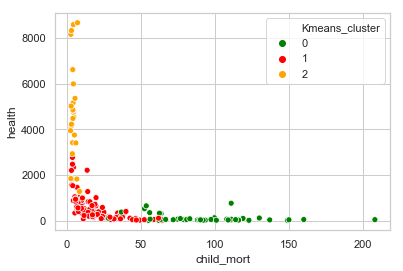

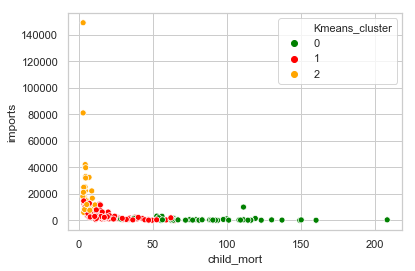

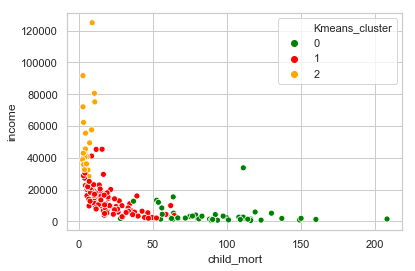

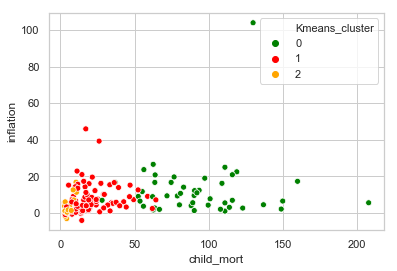

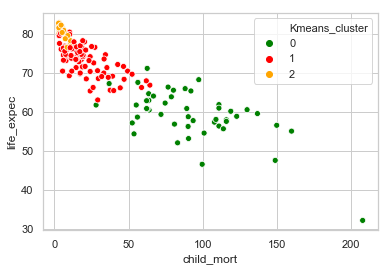

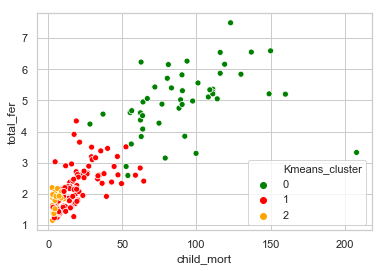

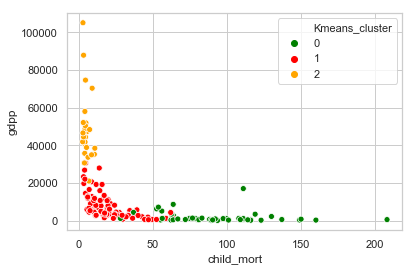

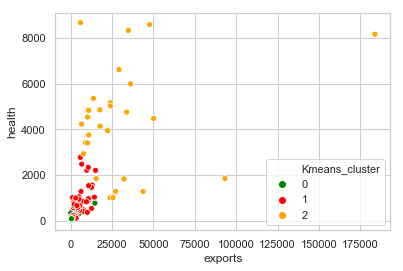

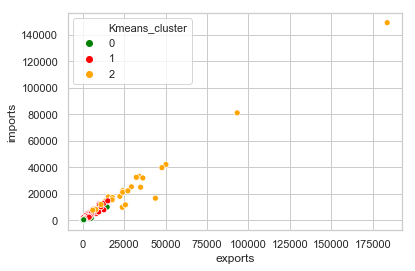

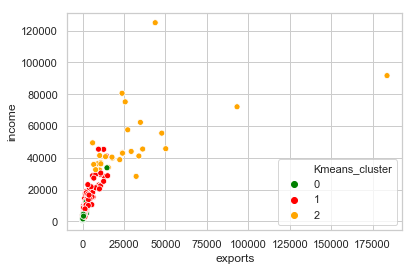

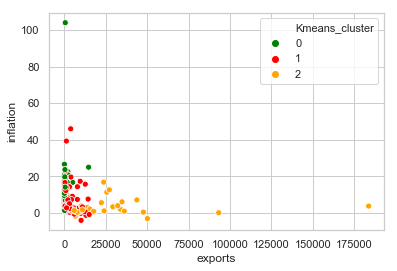

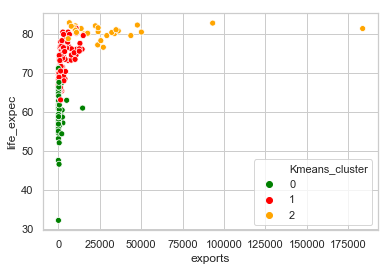

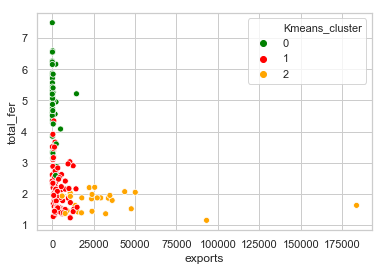

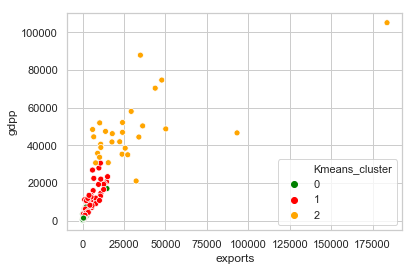

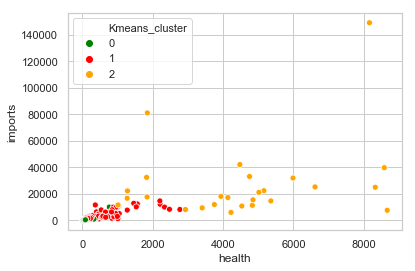

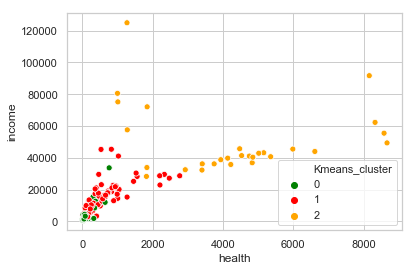

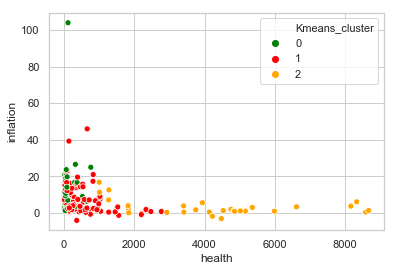

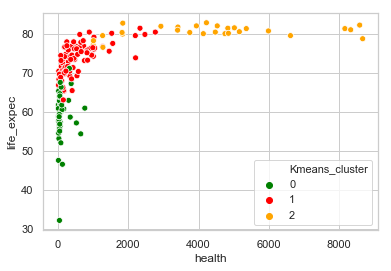

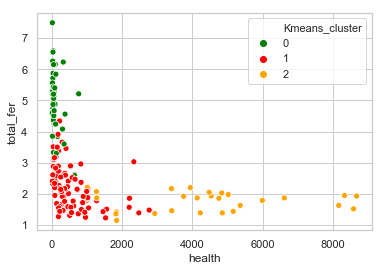

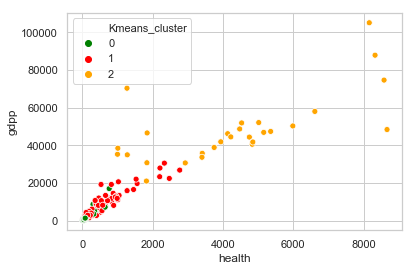

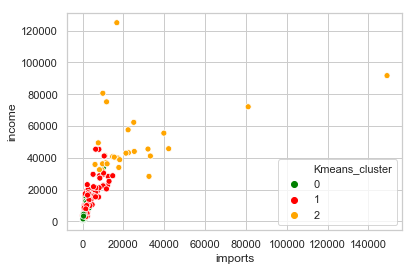

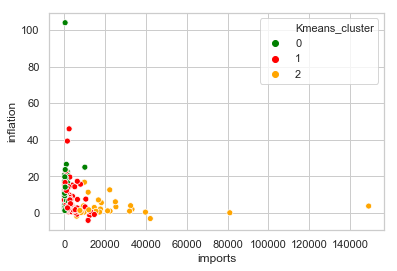

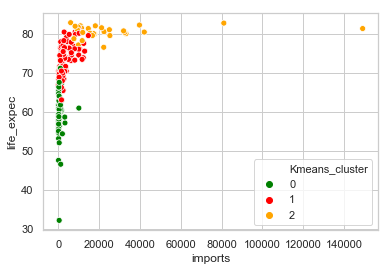

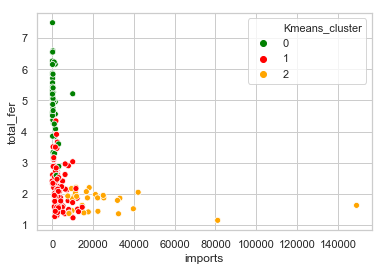

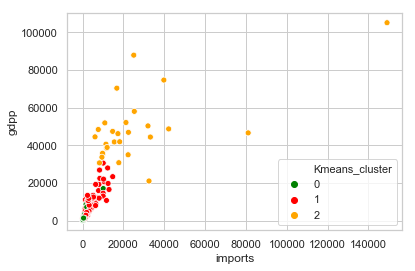

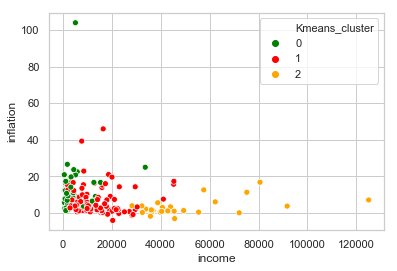

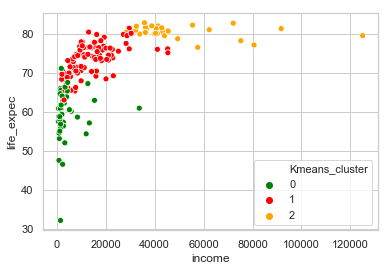

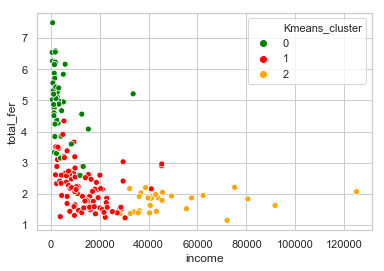

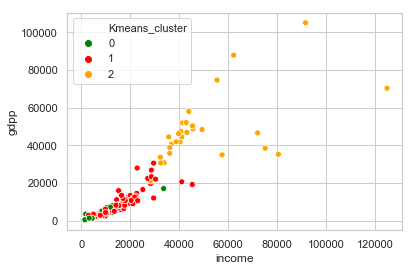

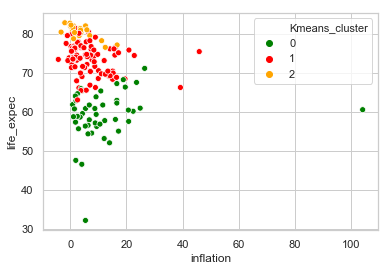

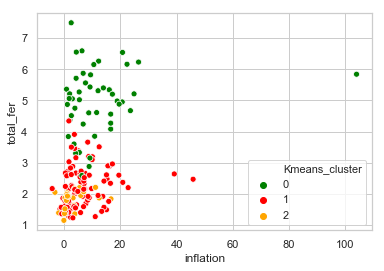

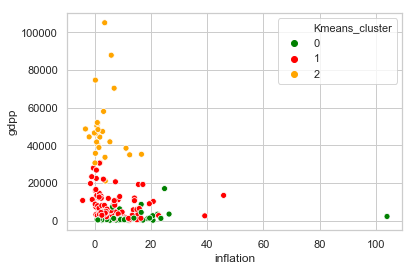

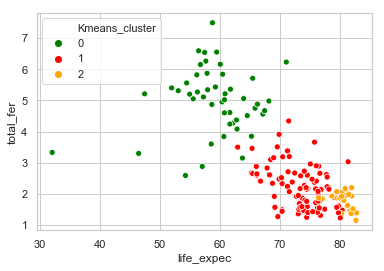

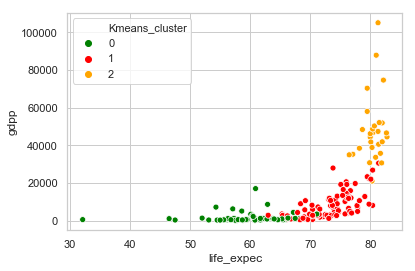

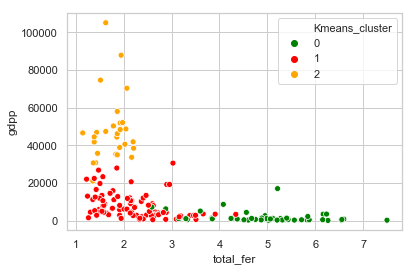

In [107]:
#Lets visualize the PCA with the clusters 
list1=[]
for i in num_cols:
    for j in num_cols:
        if i+j not in list1:
            if i != j:
                sns.scatterplot(x=i,y=j,hue='Kmeans_cluster',data=country_df,palette=['green','red','orange'])
                plt.show()
                list1.append(i+j)
                list1.append(j+i)
                

## Analysis from k means clustering
- Countries in cluster 0 have low income,low gdpp and high motality rate.
- Contries in cluster 2 have high income,high gdpp and low mortality rate.
- Countries in cluster 1 have income,gdpp and mortality rate values between cluster 1 and 2

## Hierarchial clustring 

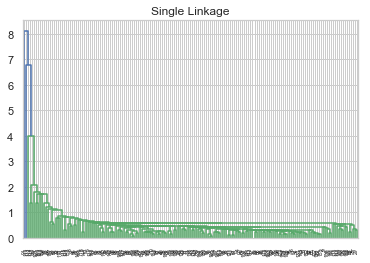

In [108]:
# single linkage
country_h = linkage(country_pca_df, method="single", metric='euclidean')
dendrogram(country_h)
plt.title("Single Linkage")
plt.show()

__There is no much clarity in the dendrogram using single linkage so lets try the complete linkage__

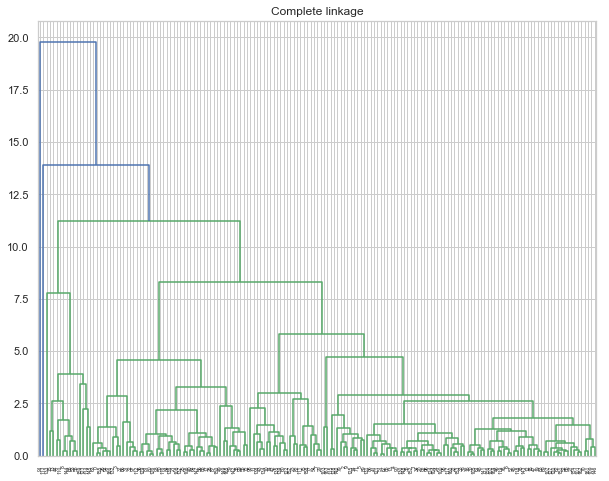

In [109]:
# complete linkage
plt.figure(figsize=(10,8))
country_h = linkage(country_pca_df, method="complete", metric='euclidean')
dendrogram(country_h)
plt.title("Complete linkage")
plt.show()

__Lets cut it at 3 cluster as we have found the optimum from our silhoette and elblow method__

In [110]:
# 3 clusters
cluster_labels = cut_tree(country_h, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [111]:
country_df['H_cluster']=cluster_labels
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Kmeans_cluster,H_cluster
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1,0


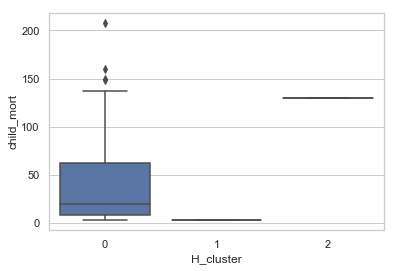

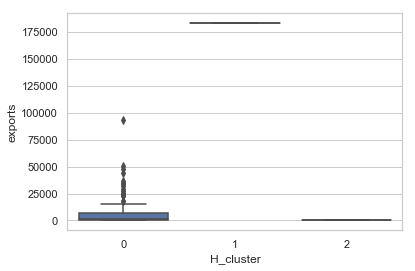

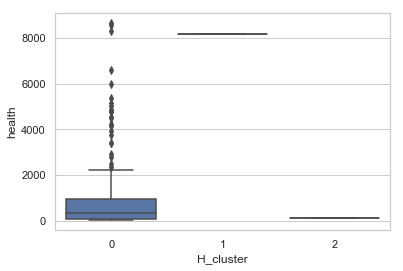

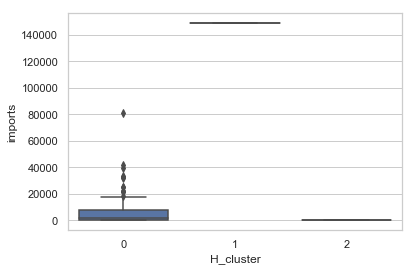

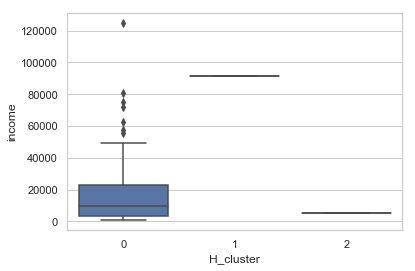

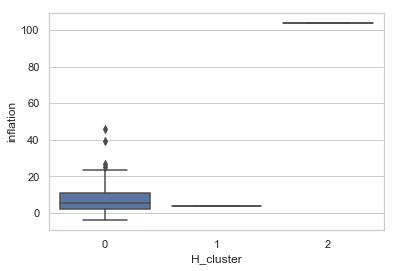

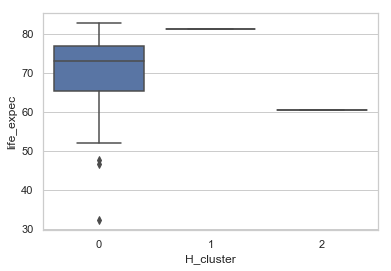

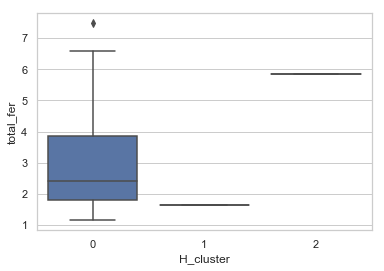

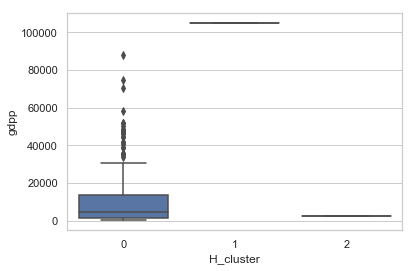

In [112]:
#lets explore the graphs

for i in num_cols:
    sns.boxplot(x='H_cluster', y=i, data=country_df)
    plt.show()

In [113]:
country_pca_new_df['H_clsuter']=cluster_labels

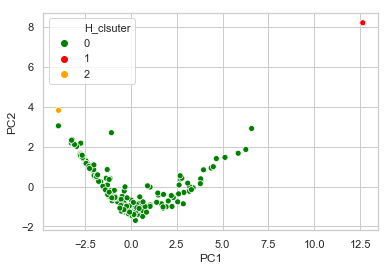

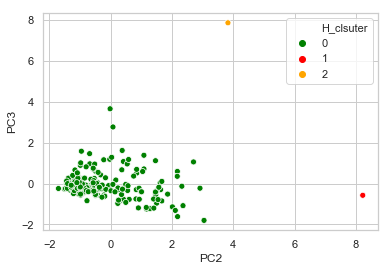

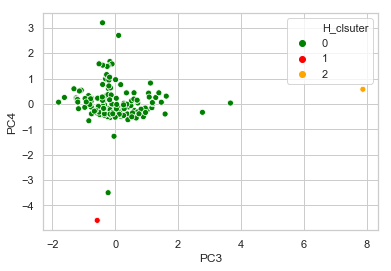

In [114]:
#visualization on PCA components 
sns.scatterplot(x='PC1',y='PC2',hue='H_clsuter',data=country_pca_new_df,legend='full',palette=['green','red','orange'])
plt.show()
sns.scatterplot(x='PC2',y='PC3',hue='H_clsuter',data=country_pca_new_df,legend='full',palette=['green','red','orange'])
plt.show()
sns.scatterplot(x='PC3',y='PC4',hue='H_clsuter',data=country_pca_new_df,legend='full',palette=['green','red','orange'])
plt.show()

## Analysis from Hierarchial clustering
- There is no clear pattern in hierarchical clustering.
- Most of the countries allign to a single cluster.
- So we do not consider hirarchical clustering 

## Final Analysis
__If we consider K means , then lets rename  the cluster labels as developed,underdeveloped and developing__ 

In [115]:
country_df['Kmeans_cluster']=country_df['Kmeans_cluster'].map({0:'underdeveloped',2:'Developed',1:'Developing'})

In [116]:
underdev_df=country_df[country_df['Kmeans_cluster']=='underdeveloped']

In [117]:
underdev_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,H_cluster
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,0.041667
std,34.319855,2252.474004,165.518331,1540.981910,5590.168621,15.362485,6.384914,1.036192,2925.911009,0.288675
min,28.100000,20.605200,12.821200,90.552000,609.000000,0.885000,32.100000,2.590000,231.000000,0.000000
25%,63.675000,102.873750,34.005875,193.319500,1390.000000,4.080000,56.725000,4.475000,551.500000,0.000000
50%,89.750000,196.260000,51.613500,339.306000,1860.000000,8.855000,59.800000,5.055000,932.000000,0.000000
75%,111.000000,552.522500,95.303250,801.000000,3522.500000,16.600000,62.825000,5.597500,1465.000000,0.000000
max,208.000000,14671.800000,766.080000,10071.900000,33700.000000,104.000000,71.100000,7.490000,17100.000000,2.000000


In [118]:
underdev_df.describe().loc['50%','child_mort']

89.75

__Selcting all the countries in  the underdevelped countries which have moratlity more than median of it values and income and gdp less than the median values__

__We have selected median as an approach due to the precense of outliers__

In [119]:

bool1=(underdev_df['child_mort'] > underdev_df.describe().loc['50%','child_mort']) & (underdev_df['income'] < underdev_df.describe().loc['50%','income']) & (underdev_df['gdpp'] < underdev_df.describe().loc['50%','gdpp'])

In [120]:
underdev_df=underdev_df[bool1]

In [121]:
underdev_df=underdev_df.sort_values(['child_mort','income','gdpp'],ascending=[False,True,True])
underdev_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Kmeans_cluster,H_cluster
66,Haiti,208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662,underdeveloped,0
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220,17.20,55.0,5.20,399,underdeveloped,0
31,Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446,underdeveloped,0
112,Niger,123.0,77.256,17.9568,170.868,814,2.55,58.8,7.49,348,underdeveloped,0
37,"Congo, Dem. Rep.",116.0,137.274,26.4194,165.664,609,20.80,57.5,6.54,334,underdeveloped,0


__I would like to suggest the below countries which need aid__

- Haiti
- Sierra Leone
- Central African Republic
- Niger
- Congo, Dem. Rep